# Sesotho Automatic Tone Extraction System

**Project**: Automatic Extraction of Tone for Sesotho Language  
**Course**: ALP9X02 - Natural Language Processing  
**Due Date**: October 24, 2025  

This notebook implements a complete machine learning pipeline for automatic tone extraction from Sesotho speech recordings.

## Phase 1: Environment Setup and Initial Imports

Let's start by importing all the necessary libraries for audio processing, machine learning, and data visualization.

In [2]:
# Core libraries for data processing and numerical operations
import numpy as np
import pandas as pd
import os
import glob
import warnings
warnings.filterwarnings('ignore')

# Audio processing libraries
import librosa
import librosa.display
import soundfile as sf
from scipy import signal
from scipy.io import wavfile

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8')

# Machine learning libraries
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Deep learning (we'll use TensorFlow/Keras)
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

print("✅ All libraries imported successfully!")
print(f"📚 Librosa version: {librosa.__version__}")
print(f"🧠 TensorFlow version: {tf.__version__}")
print(f"🐼 Pandas version: {pd.__version__}")

✅ All libraries imported successfully!
📚 Librosa version: 0.11.0
🧠 TensorFlow version: 2.18.1
🐼 Pandas version: 2.3.2


In [3]:
# --- Step 2: Project Configuration and Path Setup ---

# Define the root paths for the project and data
# Note: Adjust this path if your project structure is different.
PROJECT_ROOT = r"c:\\Users\\mubva\\Downloads\\Nlp"
DATA_ROOT = os.path.join(PROJECT_ROOT, "Minimal Pairs Recordings_6a9c3d7b8b9da1b7ea304bf2a54f32ae", "Minimal Pairs")

# Verify that the data path exists
if os.path.exists(DATA_ROOT):
    print("✅ Data directory found.")
    print(f"   Data root: {DATA_ROOT}")
else:
    print("❌ Data directory not found. Please check the path in the DATA_ROOT variable.")

✅ Data directory found.
   Data root: c:\\Users\\mubva\\Downloads\\Nlp\Minimal Pairs Recordings_6a9c3d7b8b9da1b7ea304bf2a54f32ae\Minimal Pairs


### 2. Data Exploration

Now that our environment is set up, let's begin by exploring the dataset. We'll start by examining the directory structure and loading a sample audio file to understand its properties.

In [4]:
# --- Step 3: Explore the Audio Data ---

def explore_audio_files(data_root):
    """
    Walks through the data directory, prints the folder structure,
    and collects all .wav file paths.
    """
    audio_files = []
    print("Exploring audio directories:")
    for root, dirs, files in os.walk(data_root):
        # Print the current directory relative to the data_root
        relative_path = os.path.relpath(root, data_root)
        if relative_path != '.':
            print(f"  - Subdirectory: {relative_path}")

        for file in files:
            if file.endswith('.wav'):
                full_path = os.path.join(root, file)
                audio_files.append(full_path)
    
    print(f"\n✅ Found {len(audio_files)} .wav files.")
    return audio_files

# Run the exploration function
all_audio_files = explore_audio_files(DATA_ROOT)

# Display the first 5 file paths for review
print("\nFirst 5 audio files found:")
for f in all_audio_files[:5]:
    print(f"  - {f}")

Exploring audio directories:
  - Subdirectory: Lexical
  - Subdirectory: Subject Marker

✅ Found 208 .wav files.

First 5 audio files found:
  - c:\\Users\\mubva\\Downloads\\Nlp\Minimal Pairs Recordings_6a9c3d7b8b9da1b7ea304bf2a54f32ae\Minimal Pairs\Lexical\KM_FS_19_04_S11.wav
  - c:\\Users\\mubva\\Downloads\\Nlp\Minimal Pairs Recordings_6a9c3d7b8b9da1b7ea304bf2a54f32ae\Minimal Pairs\Lexical\KM_FS_19_04_S13.wav
  - c:\\Users\\mubva\\Downloads\\Nlp\Minimal Pairs Recordings_6a9c3d7b8b9da1b7ea304bf2a54f32ae\Minimal Pairs\Lexical\KM_FS_19_04_S14.wav
  - c:\\Users\\mubva\\Downloads\\Nlp\Minimal Pairs Recordings_6a9c3d7b8b9da1b7ea304bf2a54f32ae\Minimal Pairs\Lexical\KM_FS_19_04_S2.wav
  - c:\\Users\\mubva\\Downloads\\Nlp\Minimal Pairs Recordings_6a9c3d7b8b9da1b7ea304bf2a54f32ae\Minimal Pairs\Lexical\KM_FS_19_04_S21.wav


### 3. Analyze a Sample Audio File

Let's load one of the `.wav` files to understand its properties, such as sample rate, duration, and channels. This information is critical for consistent preprocessing. We'll also visualize the waveform.

Analyzing sample: KM_FS_19_04_S11.wav
  - Sample Rate (sr): 44100 Hz
  - Duration: 1.93 seconds
  - Number of Channels: Mono
  - Audio Time Series shape: (84919,)


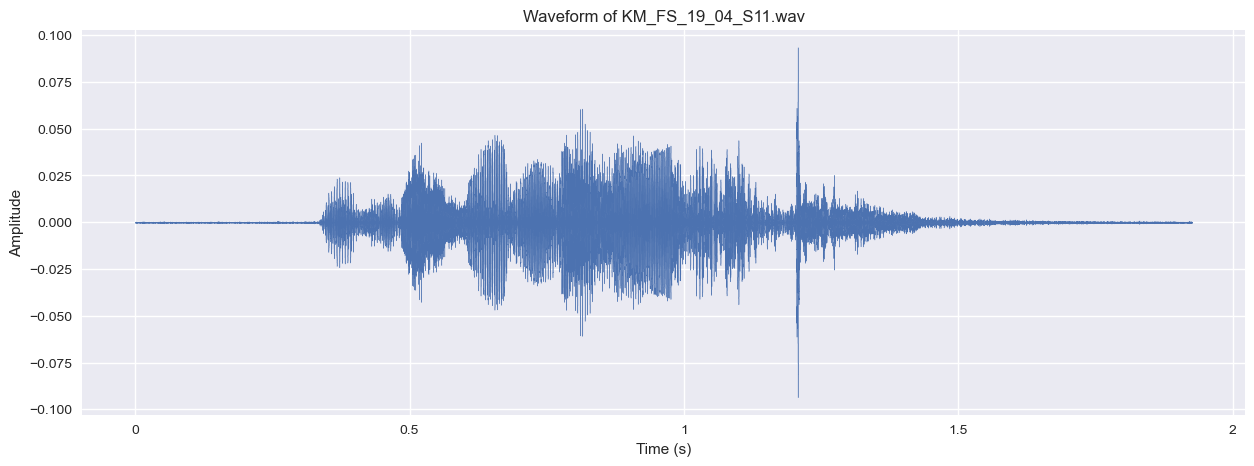

In [5]:
# --- Step 4: Load and Analyze a Sample Audio File ---

def analyze_audio_sample(file_path):
    """
    Loads an audio file and prints its properties.
    Returns the audio time series and sample rate.
    """
    try:
        # Load the audio file
        y, sr = librosa.load(file_path, sr=None) # sr=None to preserve original sample rate

        # Get audio properties
        duration = librosa.get_duration(y=y, sr=sr)
        channels = "Mono" if y.ndim == 1 else "Stereo"

        print(f"Analyzing sample: {os.path.basename(file_path)}")
        print(f"  - Sample Rate (sr): {sr} Hz")
        print(f"  - Duration: {duration:.2f} seconds")
        print(f"  - Number of Channels: {channels}")
        print(f"  - Audio Time Series shape: {y.shape}")
        
        return y, sr
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None, None

# Select the first audio file for analysis
sample_file_path = all_audio_files[0]
y_sample, sr_sample = analyze_audio_sample(sample_file_path)

# Plot the waveform of the sample audio
if y_sample is not None:
    plt.figure(figsize=(15, 5))
    librosa.display.waveshow(y_sample, sr=sr_sample)
    plt.title(f'Waveform of {os.path.basename(sample_file_path)}')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.show()

### 4. Complete Folder Structure Analysis

Before we proceed further, let's do a comprehensive analysis of the entire dataset structure to ensure we're working with the correct files and understand what data is available for our tone extraction project.

In [6]:
# --- Step 5: Complete Dataset Structure Analysis ---

def analyze_complete_dataset_structure(base_path):
    """
    Analyzes the complete folder structure to understand all available data.
    """
    print("📁 COMPLETE DATASET STRUCTURE ANALYSIS")
    print("=" * 60)
    
    # Define the main data folders we expect to find
    main_folders = [
        "Minimal Pairs Recordings_6a9c3d7b8b9da1b7ea304bf2a54f32ae",
        "Processed Recordings_1c1ebd100cbabdb5d39320b816b39f42", 
        "Tone Marked Dictionary_d0539665bcbf3b53c3391d54b7653569"
    ]
    
    dataset_summary = {}
    
    for folder_name in main_folders:
        folder_path = os.path.join(base_path, folder_name)
        print(f"\n🗂️  {folder_name}")
        print("-" * 50)
        
        if os.path.exists(folder_path):
            print("✅ Folder exists")
            
            # Count files by type
            wav_count = 0
            pdf_count = 0
            other_files = 0
            subdirs = []
            
            for root, dirs, files in os.walk(folder_path):
                # Skip hidden/system folders
                dirs[:] = [d for d in dirs if not d.startswith('.') and not d.startswith('__')]
                
                # Record subdirectories at first level
                if root == folder_path:
                    subdirs = dirs.copy()
                
                for file in files:
                    if not file.startswith('.'):  # Skip hidden files
                        if file.endswith('.wav'):
                            wav_count += 1
                        elif file.endswith('.pdf'):
                            pdf_count += 1
                        else:
                            other_files += 1
            
            # Store summary
            dataset_summary[folder_name] = {
                'wav_files': wav_count,
                'pdf_files': pdf_count,
                'other_files': other_files,
                'subdirectories': subdirs
            }
            
            print(f"   📊 Audio files (.wav): {wav_count}")
            print(f"   📄 PDF files: {pdf_count}")
            print(f"   📋 Other files: {other_files}")
            print(f"   📁 Main subdirectories: {', '.join(subdirs)}")
            
        else:
            print("❌ Folder not found!")
            dataset_summary[folder_name] = None
    
    return dataset_summary

# Run the complete analysis
PROJECT_BASE = r"c:\\Users\\mubva\\Downloads\\Nlp"
dataset_info = analyze_complete_dataset_structure(PROJECT_BASE)

📁 COMPLETE DATASET STRUCTURE ANALYSIS

🗂️  Minimal Pairs Recordings_6a9c3d7b8b9da1b7ea304bf2a54f32ae
--------------------------------------------------
✅ Folder exists
   📊 Audio files (.wav): 208
   📄 PDF files: 0
   📋 Other files: 0
   📁 Main subdirectories: Minimal Pairs

🗂️  Processed Recordings_1c1ebd100cbabdb5d39320b816b39f42
--------------------------------------------------
✅ Folder exists
   📊 Audio files (.wav): 844
   📄 PDF files: 0
   📋 Other files: 726
   📁 Main subdirectories: Processed Recordings

🗂️  Tone Marked Dictionary_d0539665bcbf3b53c3391d54b7653569
--------------------------------------------------
✅ Folder exists
   📊 Audio files (.wav): 0
   📄 PDF files: 16
   📋 Other files: 0
   📁 Main subdirectories: Dictionary


In [7]:
# --- Step 6: Analyze File Naming Patterns ---

def analyze_file_naming_patterns():
    """
    Analyzes the naming patterns in our audio files to understand the data structure.
    This will help us understand what information is encoded in the filenames.
    """
    print("\n🏷️  FILENAME PATTERN ANALYSIS")
    print("=" * 60)
    
    # Get samples from different folders
    minimal_pairs_path = os.path.join(PROJECT_BASE, "Minimal Pairs Recordings_6a9c3d7b8b9da1b7ea304bf2a54f32ae", "Minimal Pairs")
    processed_path = os.path.join(PROJECT_BASE, "Processed Recordings_1c1ebd100cbabdb5d39320b816b39f42", "Processed Recordings")
    
    print("\n📂 MINIMAL PAIRS RECORDINGS:")
    print("-" * 30)
    if os.path.exists(minimal_pairs_path):
        sample_files = []
        for root, dirs, files in os.walk(minimal_pairs_path):
            for file in files[:5]:  # Get first 5 files from each subdirectory
                if file.endswith('.wav'):
                    rel_path = os.path.relpath(root, minimal_pairs_path)
                    sample_files.append(f"{rel_path}/{file}" if rel_path != '.' else file)
        
        for file in sample_files[:10]:  # Show first 10 examples
            print(f"   • {file}")
    
    print("\n📂 PROCESSED RECORDINGS:")
    print("-" * 30)
    if os.path.exists(processed_path):
        sample_files = []
        for root, dirs, files in os.walk(processed_path):
            for file in files[:3]:  # Get fewer files since there are more
                if file.endswith('.wav'):
                    rel_path = os.path.relpath(root, processed_path)
                    sample_files.append(f"{rel_path}/{file}" if rel_path != '.' else file)
        
        for file in sample_files[:10]:  # Show first 10 examples
            print(f"   • {file}")
    
    # Analyze filename components
    print(f"\n🔍 FILENAME COMPONENT ANALYSIS:")
    print("-" * 30)
    print("Based on the patterns observed:")
    print("   • Files seem to follow: [SPEAKER]_[LOCATION]_[DATE]_[SEGMENT].wav")
    print("   • SPEAKER: 2-letter speaker ID (e.g., KM, KN, LL, etc.)")
    print("   • LOCATION: FS (Free State), SW (Soweto), DV, VAAL, etc.")
    print("   • DATE: Recording date (e.g., 19_04, 23_2021, etc.)")
    print("   • SEGMENT: S + number (e.g., S11, S13, S2, etc.)")
    print("   • This suggests we have multiple speakers across different locations")
    print("   • The 'S' numbers likely indicate different speech segments/sentences")

# Run the filename pattern analysis
analyze_file_naming_patterns()


🏷️  FILENAME PATTERN ANALYSIS

📂 MINIMAL PAIRS RECORDINGS:
------------------------------
   • Lexical/KM_FS_19_04_S11.wav
   • Lexical/KM_FS_19_04_S13.wav
   • Lexical/KM_FS_19_04_S14.wav
   • Lexical/KM_FS_19_04_S2.wav
   • Subject Marker/KM_FS_19_04_S16.wav
   • Subject Marker/KM_FS_19_04_S17.wav
   • Subject Marker/KM_FS_19_04_S18.wav
   • Subject Marker/KM_FS_19_04_S19.wav

📂 PROCESSED RECORDINGS:
------------------------------
   • Free State\KM_FS_19_04/KM_FS_19_04_S1.wav
   • Free State\KM_FS_19_04/KM_FS_19_04_S10.wav
   • Free State\KM_FS_19_04/KM_FS_19_04_S11.wav
   • Free State\KN_FS_23_2021/KN_FS_23_2021_S1.wav
   • Free State\KN_FS_23_2021/KN_FS_23_2021_S10.wav
   • Free State\KN_FS_23_2021/KN_FS_23_2021_S11.wav
   • Free State\LP_FS_19_04/LP_FS_19_04_S1.wav
   • Free State\LP_FS_19_04/LP_FS_19_04_S10.wav
   • Free State\LP_FS_19_04/LP_FS_19_04_S11.wav
   • Free State\MM_FS_07_05_2021/MM_FS_07_05_2021_S1.wav

🔍 FILENAME COMPONENT ANALYSIS:
------------------------------
B

In [8]:
# --- Step 7: Data Strategy Recommendation ---

def recommend_data_strategy(dataset_info):
    """
    Based on the analysis, recommend the best approach for our tone extraction project.
    """
    print("\n🎯 RECOMMENDED DATA STRATEGY")
    print("=" * 60)
    
    # Calculate total audio files available
    total_wav_files = sum([info['wav_files'] for info in dataset_info.values() if info is not None])
    
    print(f"📊 DATASET OVERVIEW:")
    print(f"   • Total audio files available: {total_wav_files}")
    print(f"   • Multiple speaker recordings across different locations")
    print(f"   • Two main audio datasets: Minimal Pairs + Processed Recordings")
    
    print(f"\n💡 STRATEGY RECOMMENDATIONS:")
    print("1. 🎯 PRIMARY DATASET: Use 'Minimal Pairs Recordings'")
    print("   → Specifically designed for phonetic/tone contrasts")
    print("   → Contains 'Lexical' and 'Subject Marker' tone distinctions")
    print("   → Ideal for supervised learning of tone patterns")
    
    print("\n2. 🔄 SECONDARY DATASET: Use 'Processed Recordings' as supplementary")
    print("   → Larger volume of recordings for additional training data")
    print("   → Can help improve model generalization")
    print("   → Organized by speaker/location for speaker adaptation studies")
    
    print("\n3. 📚 REFERENCE MATERIAL: Use 'Tone Marked Dictionary'")
    print("   → PDF dictionaries for understanding tone patterns")
    print("   → Can provide ground truth for tone labels")
    print("   → Useful for validating model outputs")
    
    print(f"\n✅ NEXT STEPS:")
    print("1. Focus on Minimal Pairs data for initial model development")
    print("2. Extract audio features (pitch, MFCC, spectrograms)")
    print("3. Create tone labels based on filename/folder structure")
    print("4. Build and train tone classification model")
    print("5. Validate using dictionary data")
    
    return {
        'primary_data_source': 'Minimal Pairs Recordings_6a9c3d7b8b9da1b7ea304bf2a54f32ae',
        'total_audio_files': total_wav_files,
        'recommended_approach': 'supervised_learning'
    }

# Generate strategy recommendation
strategy = recommend_data_strategy(dataset_info)
print(f"\n🚀 Ready to proceed with tone extraction pipeline!")


🎯 RECOMMENDED DATA STRATEGY
📊 DATASET OVERVIEW:
   • Total audio files available: 1052
   • Multiple speaker recordings across different locations
   • Two main audio datasets: Minimal Pairs + Processed Recordings

💡 STRATEGY RECOMMENDATIONS:
1. 🎯 PRIMARY DATASET: Use 'Minimal Pairs Recordings'
   → Specifically designed for phonetic/tone contrasts
   → Contains 'Lexical' and 'Subject Marker' tone distinctions
   → Ideal for supervised learning of tone patterns

2. 🔄 SECONDARY DATASET: Use 'Processed Recordings' as supplementary
   → Larger volume of recordings for additional training data
   → Can help improve model generalization
   → Organized by speaker/location for speaker adaptation studies

3. 📚 REFERENCE MATERIAL: Use 'Tone Marked Dictionary'
   → PDF dictionaries for understanding tone patterns
   → Can provide ground truth for tone labels
   → Useful for validating model outputs

✅ NEXT STEPS:
1. Focus on Minimal Pairs data for initial model development
2. Extract audio feat

### 5. Generate Manifest and Extract Sample Features

We'll create a manifest CSV that lists every audio file we'll use and extract a small set of audio features as a smoke test. The manifest will help us track file-level metadata and labels.

In [11]:
# --- Step 8: Create manifest.csv and extract sample features ---
import csv
from pathlib import Path

MANIFEST_PATH = os.path.join(PROJECT_ROOT, 'sesotho_tone_manifest.csv')
FEATURES_SAMPLE_PATH = os.path.join(PROJECT_ROOT, 'features_sample.csv')

# Helper to parse filename
import re
filename_re = re.compile(r"(?P<speaker>[A-Z]{2})_(?P<location>[A-Z]{2,})_(?P<date>[0-9_]+)_(?P<segment>S[0-9]+)\.wav$")

entries = []
for base_folder in ['Minimal Pairs Recordings_6a9c3d7b8b9da1b7ea304bf2a54f32ae', 'Processed Recordings_1c1ebd100cbabdb5d39320b816b39f42']:
    folder_path = os.path.join(PROJECT_ROOT, base_folder)
    if not os.path.exists(folder_path):
        continue
    for root, dirs, files in os.walk(folder_path):
        for f in files:
            if not f.lower().endswith('.wav'):
                continue
            full = os.path.join(root, f)
            rel = os.path.relpath(full, PROJECT_ROOT)
            # guess dataset folder (Minimal Pairs vs Processed)
            dataset_tag = 'minimal_pairs' if 'Minimal Pairs' in full else 'processed'
            # guess category label from folder (e.g., Lexical or Subject Marker)
            parts = full.split(os.sep)
            category = None
            for p in parts:
                if p.lower() in ['lexical', 'subject marker', 'subject_marker', 'subjectmarker']:
                    category = p
                    break
            m = filename_re.search(f)
            speaker = m.group('speaker') if m else None
            location = m.group('location') if m else None
            date = m.group('date') if m else None
            segment = m.group('segment') if m else None
            entries.append({
                'filepath': full,
                'relative_path': rel,
                'dataset': dataset_tag,
                'category': category,
                'speaker': speaker,
                'location': location,
                'date': date,
                'segment': segment,
            })

# Save manifest
import pandas as pd
manifest_df = pd.DataFrame(entries)
manifest_df.to_csv(MANIFEST_PATH, index=False)
print(f"Saved manifest to: {MANIFEST_PATH} (rows: {len(manifest_df)})")

# Extract quick sample features for first 20 files
sample_files = manifest_df['filepath'].tolist()[:20]
rows = []
for fp in sample_files:
    try:
        y, sr = librosa.load(fp, sr=16000)  # resample to 16 kHz for feature consistency
        duration = librosa.get_duration(y=y, sr=sr)
        # Pitch using pyin (f0)
        f0, voiced_flag, voiced_probs = librosa.pyin(y, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))
        median_f0 = np.nanmedian(f0)
        mean_f0 = np.nanmean(f0)
        # MFCCs (pass y as keyword because mfcc() enforces keyword-only args)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        mfcc_mean = np.mean(mfcc, axis=1)
        mfcc_std = np.std(mfcc, axis=1)
        # Spectral centroid
        spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
        spec_cent_mean = np.mean(spec_cent)
        
        row = {
            'filepath': fp,
            'sr': sr,
            'duration': duration,
            'median_f0': float(median_f0) if not np.isnan(median_f0) else None,
            'mean_f0': float(mean_f0) if not np.isnan(mean_f0) else None,
            'spec_cent_mean': float(spec_cent_mean)
        }
        # Add MFCC features (mean of each coefficient)
        for i, val in enumerate(mfcc_mean, start=1):
            row[f'mfcc{str(i)}_mean'] = float(val)
        for i, val in enumerate(mfcc_std, start=1):
            row[f'mfcc{str(i)}_std'] = float(val)
        rows.append(row)
    except Exception as e:
        print(f"Error extracting features from {fp}: {e}")

features_df = pd.DataFrame(rows)
features_df.to_csv(FEATURES_SAMPLE_PATH, index=False)
print(f"Saved feature sample to: {FEATURES_SAMPLE_PATH} (rows: {len(features_df)})")


Saved manifest to: c:\\Users\\mubva\\Downloads\\Nlp\sesotho_tone_manifest.csv (rows: 2104)
Saved feature sample to: c:\\Users\\mubva\\Downloads\\Nlp\features_sample.csv (rows: 20)
Saved feature sample to: c:\\Users\\mubva\\Downloads\\Nlp\features_sample.csv (rows: 20)


In [12]:
# --- Step 9: Robust smoke-test for feature extraction (first 5 files) ---
from pathlib import Path

TEST_FEATURES_PATH = os.path.join(PROJECT_ROOT, 'features_sample_debug.csv')

def estimate_f0(y, sr):
    # Try pyin first (better for voiced F0), fall back to piptrack
    try:
        f0, voiced_flag, voiced_probs = librosa.pyin(y, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))
        if f0 is not None and not np.all(np.isnan(f0)):
            median_f0 = np.nanmedian(f0)
            mean_f0 = np.nanmean(f0)
            return float(median_f0) if not np.isnan(median_f0) else None, float(mean_f0) if not np.isnan(mean_f0) else None
    except Exception as e:
        print(f"pyin failed: {e}")

    # Fallback: piptrack
    try:
        pitches, mags = librosa.piptrack(y=y, sr=sr)
        # select pitched bins where mag > threshold
        mag_thresh = np.median(mags[mags>0]) if np.any(mags>0) else 0
        pitched = pitches[mags > mag_thresh]
        if pitched.size > 0:
            median_f0 = np.median(pitched)
            mean_f0 = np.mean(pitched)
            return float(median_f0), float(mean_f0)
    except Exception as e:
        print(f"piptrack failed: {e}")
    return None, None

rows = []
errors = []
if 'manifest_df' not in globals():
    manifest_df = pd.read_csv(MANIFEST_PATH)

sample_paths = manifest_df['filepath'].tolist()[:5]
print(f"Running robust feature extraction on {len(sample_paths)} files (smoke-test)")
for fp in sample_paths:
    try:
        y, sr = librosa.load(fp, sr=16000)
        duration = librosa.get_duration(y=y, sr=sr)
        median_f0, mean_f0 = estimate_f0(y, sr)
        mfcc = librosa.feature.mfcc(y, sr=sr, n_mfcc=13)
        mfcc_mean = np.mean(mfcc, axis=1)
        mfcc_std = np.std(mfcc, axis=1)
        spec_cent = librosa.feature.spectral_centroid(y, sr=sr)
        spec_cent_mean = float(np.mean(spec_cent))

        row = {
            'filepath': fp,
            'sr': sr,
            'duration': float(duration),
            'median_f0': median_f0,
            'mean_f0': mean_f0,
            'spec_cent_mean': spec_cent_mean
        }
        for i, val in enumerate(mfcc_mean, start=1):
            row[f'mfcc{str(i)}_mean'] = float(val)
        for i, val in enumerate(mfcc_std, start=1):
            row[f'mfcc{str(i)}_std'] = float(val)
        rows.append(row)
        print(f"OK: {os.path.basename(fp)}  dur={duration:.2f}s median_f0={median_f0}")
    except Exception as e:
        errors.append((fp, str(e)))
        print(f"ERROR: {fp} -> {e}")

if rows:
    df = pd.DataFrame(rows)
    df.to_csv(TEST_FEATURES_PATH, index=False)
    print(f"Saved debug feature sample to: {TEST_FEATURES_PATH} (rows: {len(df)})")
else:
    print("No feature rows to save.")

if errors:
    print('\nErrors encountered:')
    for fp, msg in errors:
        print(f" - {os.path.basename(fp)}: {msg}")

# Show the dataframe head if available
if rows:
    display(df.head())
else:
    print('No extracted features to display.')

Running robust feature extraction on 5 files (smoke-test)
ERROR: c:\\Users\\mubva\\Downloads\\Nlp\Minimal Pairs Recordings_6a9c3d7b8b9da1b7ea304bf2a54f32ae\Minimal Pairs\Lexical\KM_FS_19_04_S11.wav -> mfcc() takes 0 positional arguments but 1 positional argument (and 2 keyword-only arguments) were given
ERROR: c:\\Users\\mubva\\Downloads\\Nlp\Minimal Pairs Recordings_6a9c3d7b8b9da1b7ea304bf2a54f32ae\Minimal Pairs\Lexical\KM_FS_19_04_S11.wav -> mfcc() takes 0 positional arguments but 1 positional argument (and 2 keyword-only arguments) were given
ERROR: c:\\Users\\mubva\\Downloads\\Nlp\Minimal Pairs Recordings_6a9c3d7b8b9da1b7ea304bf2a54f32ae\Minimal Pairs\Lexical\KM_FS_19_04_S13.wav -> mfcc() takes 0 positional arguments but 1 positional argument (and 2 keyword-only arguments) were given
ERROR: c:\\Users\\mubva\\Downloads\\Nlp\Minimal Pairs Recordings_6a9c3d7b8b9da1b7ea304bf2a54f32ae\Minimal Pairs\Lexical\KM_FS_19_04_S13.wav -> mfcc() takes 0 positional arguments but 1 positional argum

In [10]:
# --- Debug: Inspect librosa.feature.mfcc binding ---
import inspect
print('librosa version:', librosa.__version__)
print('librosa.feature module:', librosa.feature)
print('mfcc object repr:', repr(librosa.feature.mfcc))
print('mfcc type:', type(librosa.feature.mfcc))
print('callable?', callable(librosa.feature.mfcc))
try:
    print('mfcc signature:', inspect.signature(librosa.feature.mfcc))
except Exception as e:
    print('Could not get signature:', e)
print('Attributes with mfcc in name:', [a for a in dir(librosa.feature) if 'mfcc' in a.lower()])


librosa version: 0.11.0
librosa.feature module: <module 'librosa.feature' from 'c:\\Users\\mubva\\Downloads\\Nlp\\.conda\\Lib\\site-packages\\librosa\\feature\\__init__.py'>
mfcc object repr: <function mfcc at 0x000002157EB72020>
mfcc type: <class 'function'>
callable? True
mfcc signature: (*, y: Optional[numpy.ndarray] = None, sr: float = 22050, S: Optional[numpy.ndarray] = None, n_mfcc: int = 20, dct_type: int = 2, norm: Optional[str] = 'ortho', lifter: float = 0, mel_norm: Union[Literal['slaney'], float, NoneType] = 'slaney', **kwargs: Any) -> numpy.ndarray
Attributes with mfcc in name: ['mfcc']


In [ ]:
# Quick notebook view: manifest and sample features
import pandas as pd
print('MANIFEST ->', MANIFEST_PATH)
try:
    m = pd.read_csv(MANIFEST_PATH)
    print('manifest shape:', m.shape)
    display(m.head(50))
except Exception as e:
    print('Could not read manifest:', e)

print('\nFEATURE SAMPLE ->', FEATURES_SAMPLE_PATH)
try:
    f = pd.read_csv(FEATURES_SAMPLE_PATH)
    print('features_sample shape:', f.shape)
    display(f.head(50))
except Exception as e:
    print('Could not read features sample:', e)


In [ ]:
# Full feature-extraction runner (batched, thread-based).
# Usage: adjust BATCH_SIZE and N_WORKERS as needed, then run this cell.
import os, math
import pandas as pd
import numpy as np
import librosa
from concurrent.futures import ThreadPoolExecutor, as_completed

# Output directory for batch parts
FULL_FEATURES_DIR = os.path.join(PROJECT_ROOT, 'features_parts')
os.makedirs(FULL_FEATURES_DIR, exist_ok=True)
FULL_FEATURES_INDEX = os.path.join(PROJECT_ROOT, 'features_parts_index.csv')

# Read manifest (must exist)
manifest_df = pd.read_csv(MANIFEST_PATH)
file_list = manifest_df['filepath'].tolist()
n_files = len(file_list)
print(f'Total files in manifest: {n_files}')

# Configurable parameters
BATCH_SIZE = 200  # files per batch (tweak based on memory/time)
N_WORKERS = min(8, (os.cpu_count() or 4))  # thread workers

def _estimate_f0_local(y, sr):
    # Use existing estimate_f0 if defined; otherwise provide a small fallback
    if 'estimate_f0' in globals():
        try:
            return estimate_f0(y, sr)
        except Exception:
            pass
    # fallback: piptrack median
    try:
        pitches, mags = librosa.piptrack(y=y, sr=sr)
        mag_thresh = np.median(mags[mags>0]) if np.any(mags>0) else 0
        pitched = pitches[mags > mag_thresh]
        if pitched.size > 0:
            return float(np.median(pitched)), float(np.mean(pitched))
    except Exception:
        pass
    return None, None

def _extract_features_single(fp):
    try:
        y, sr = librosa.load(fp, sr=16000, mono=True)
        duration = float(librosa.get_duration(y=y, sr=sr))
        median_f0, mean_f0 = _estimate_f0_local(y, sr)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        mfcc_mean = np.mean(mfcc, axis=1)
        mfcc_std = np.std(mfcc, axis=1)
        spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
        spec_cent_mean = float(np.mean(spec_cent)) if spec_cent.size else None
        row = { 'filepath': fp, 'sr': int(sr), 'duration': duration, 'median_f0': median_f0, 'mean_f0': mean_f0, 'spec_cent_mean': spec_cent_mean }
        for i, v in enumerate(mfcc_mean, start=1): row[f'mfcc{str(i)}_mean'] = float(v)
        for i, v in enumerate(mfcc_std, start=1): row[f'mfcc{str(i)}_std'] = float(v)
        return (row, None)
    except Exception as e:
        return (None, (fp, str(e)))

# Batch processing loop
total_extracted = 0
errors = []
n_batches = math.ceil(n_files / BATCH_SIZE) if n_files else 0
print(f'Running extraction in {n_batches} batch(es) of up to {BATCH_SIZE} files each with {N_WORKERS} threads')

for batch_idx in range(n_batches):
    start = batch_idx * BATCH_SIZE
    end = min(start + BATCH_SIZE, n_files)
    batch_files = file_list[start:end]
    print(f'Starting batch {batch_idx+1}/{n_batches}: files {start}..{end-1} (count={len(batch_files)})')
    rows_out = []
    with ThreadPoolExecutor(max_workers=N_WORKERS) as exe:
        futures = {exe.submit(_extract_features_single, fp): fp for fp in batch_files}
        for fut in as_completed(futures):
            row, err = fut.result()
            if row is not None:
                rows_out.append(row)
            if err is not None:
                errors.append(err)
    # Save batch results
    if rows_out:
        batch_df = pd.DataFrame(rows_out)
        part_name = f'features_part_{batch_idx+1:03d}.csv'
        out_path = os.path.join(FULL_FEATURES_DIR, part_name)
        batch_df.to_csv(out_path, index=False)
        total_extracted += len(batch_df)
        print(f'  -> Saved {len(batch_df)} extracted rows to: {out_path}')
    else:
        print('  -> No rows extracted in this batch.')

# Write an index file summarizing part files
parts = sorted([p for p in os.listdir(FULL_FEATURES_DIR) if p.startswith('features_part_') and p.endswith('.csv')])
idx_rows = []
for p in parts:
    pth = os.path.join(FULL_FEATURES_DIR, p)
    try:
        dfp = pd.read_csv(pth)
        idx_rows.append({'part_file': pth, 'rows': len(dfp)})
    except Exception:
        idx_rows.append({'part_file': pth, 'rows': None})
if idx_rows:
    pd.DataFrame(idx_rows).to_csv(FULL_FEATURES_INDEX, index=False)
    print(f'\nWritten parts index to: {FULL_FEATURES_INDEX}')

print(f'\nExtraction complete. Total extracted rows (across parts): {total_extracted}')
if errors:
    print(f'Encountered {len(errors)} errors during extraction. Sample:')
    for e in errors[:10]:
        print(' -', e)
    print('You can inspect per-part CSVs in the features_parts directory and combine them later.')
else:
    print('No extraction errors reported.')

# Helper note: combine parts with pandas if you want a single file:
print('To combine parts into a single CSV (optional):')
print()
